<a href="https://colab.research.google.com/github/DJCordhose/mlops-drift/blob/main/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training, Re-Train on new data, re-engineer training

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
def url_for_dataset(relative_path):
  if IN_COLAB:
    url = f'https://github.com/DJCordhose/buch-machine-learning-notebooks/raw/main/kap11/datasets/insurance_prediction/{relative_path}.csv.gz'
  else:
    url =  f'./datasets/insurance_prediction/{relative_path}.csv.gz'
  return url

In [3]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

2023-12-03 12:15:30.942037: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 12:15:31.005222: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 12:15:31.207747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 12:15:31.207781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 12:15:31.208480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

'2.14.0'

In [4]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [5]:
tf.random.set_seed(42)

In [6]:
import numpy as np
np.__version__

'1.26.1'

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [8]:
if IN_COLAB:
    !pip install -q lrcurve

In [9]:
# https://github.com/AndreasMadsen/python-lrcurve
from lrcurve import KerasLearningCurve

# Step 1: Choosing data set to train on

In [10]:
use_new_data_for_training = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [11]:
import pandas as pd

if not use_new_data_for_training:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')

In [12]:
df.head()

,training,age,emergency_braking,braking_distance,power,milage,risk,group_name,group,good_customer
0,0,41.951100,0,40.933328,122.238329,98.509765,3.705528,high,0,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.442419,medium,1,0
2,0,18.314649,1,41.587241,143.427269,76.862968,4.074379,high,0,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.093286,high,0,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.733844,high,0,0


In [13]:
df.describe()

,training,age,emergency_braking,braking_distance,power,milage,risk,group,good_customer
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.182905,0.902000,0.436667
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481600,0.815377,0.496138
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.283898,0.000000,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.711191,0.000000,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.388913,1.000000,0.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874870,2.000000,1.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.348509,2.000000,1.000000


# Step 2: Preparing data

In [14]:
# comment in or even add more dropped features

def drop_unimportant_features(df):
    # in the future we will only see samples with emergency braking
    # df = df[df['emergency_braking'] == 1]
    # drop features that no longer have a significant impact on prediction to avoid overfitting
    # df.drop(['emergency_braking'], axis='columns', inplace=True)
    return df


In [15]:
df = drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [16]:
df.describe()

,training,age,emergency_braking,braking_distance,power,milage,risk,group,good_customer
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.182905,0.902000,0.436667
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481600,0.815377,0.496138
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.283898,0.000000,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.711191,0.000000,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.388913,1.000000,0.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874870,2.000000,1.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.348509,2.000000,1.000000


In [18]:
y = df['good_customer'].values  # binary classification
np.unique(y, return_counts=True)

(array([0, 1]), array([845, 655]))

In [19]:
df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns', inplace=True)

In [20]:
df = df.round(1)
df.head(10)

,training,age,emergency_braking,braking_distance,power,milage
0,0,42.0,0,40.9,122.2,98.5
1,0,24.4,1,44.8,113.8,46.3
2,0,18.3,1,41.6,143.4,76.9
3,0,51.3,1,47.3,111.6,102.7
4,0,23.6,0,42.8,146.0,63.7
5,0,29.5,1,46.5,139.8,66.6
6,0,21.3,1,40.7,134.7,63.1
7,1,47.5,0,35.2,142.2,123.4
8,1,20.6,1,41.8,114.7,103.9
9,0,24.6,1,40.8,162.5,44.3


In [21]:

from sklearn.model_selection import train_test_split
X = df.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

# Step 3a: Establishing baseline for categories

In [22]:
LOW_RISK = 2
MEDIUM_RISK = 1
HIGH_RISK = 0

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [23]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
base_clf = RandomClassifier()    
base_clf.score(X_test, y_test)

0.31333333333333335

In [24]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1]), array([676, 524]))

In [25]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return HIGH_RISK
base_clf = NaiveClassifier()    
base_clf.score(X_test, y_test)

0.5633333333333334

In [26]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, milage = x
#         print(age, power, milage)
        if training: 
            return LOW_RISK
        if age < 30:
            if power > 130:
                return HIGH_RISK
            else:
                return MEDIUM_RISK
        if age > 50:
            return HIGH_RISK
        if emergency_braking:
            return LOW_RISK
        if milage > 50:
            return HIGH_RISK
        if milage > 30:
            return MEDIUM_RISK
        # default
        return LOW_RISK
base_clf = BaseLineClassifier() 
base_clf.score(X_test, y_test)

0.41333333333333333

# Step 3b: Baseline for binary classifier

In [27]:
class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [28]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(0, 2)
base_clf = RandomClassifier()    
base_clf.score(X_test, y_test)

0.52

In [29]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1]), array([676, 524]))

In [30]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return 0
base_clf = NaiveClassifier()    
base_clf.score(X_test, y_test)

0.5633333333333334

In [31]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, milage = x
        if training: 
            return 1
        if age < 30:
            if power > 100:
                return 0
        if age > 55:
            return 0
        if emergency_braking:
            return 1
        if milage > 50:
            return 0
        # default
        return 0
base_clf = BaseLineClassifier() 
base_clf.score(X_test, y_test)

0.7733333333333333

# Step 4: Training Keras model

In [32]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
# takes mean and variance from X_train for normalization
normalizer.adapt(X_train)

In [33]:
# this output and output from next cell are the same
X_train.mean(axis=0), X_train.var(axis=0)

(array([  0.21083333,  35.20791667,   0.39916667,  39.95533333,
        135.62941667,  80.86933333]),
 array([1.66382639e-01, 1.67871012e+02, 2.39832639e-01, 2.31307882e+01,
        1.22778484e+03, 6.37994843e+02]))

In [34]:
normalizer.mean, normalizer.variance

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.21083328,  35.207924  ,   0.39916658,  39.955334  ,
         135.6294    ,  80.869354  ]], dtype=float32)>,
 <tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[1.6638267e-01, 1.6787103e+02, 2.3983261e-01, 2.3130787e+01,
         1.2277850e+03, 6.3799475e+02]], dtype=float32)>)

In [35]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation


num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# model.add(Dense(neurons_per_layer, name='hidden3'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

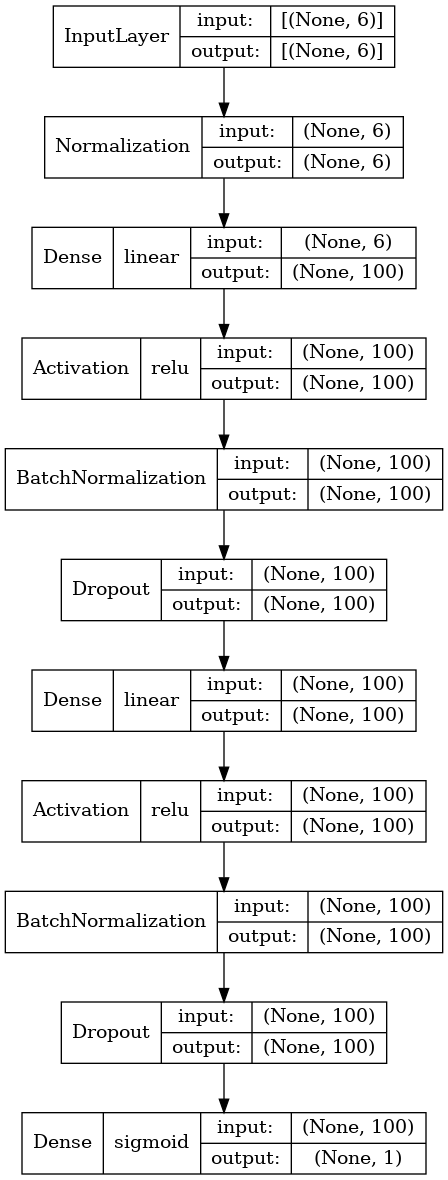

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True)

In [37]:
%%time

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 75

loss = 'binary_crossentropy'

model.compile(loss=loss,
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    # validation_data=(X_test, y_test),
                    validation_split=0.2,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 9.78 s, sys: 2.07 s, total: 11.9 s
Wall time: 10.1 s


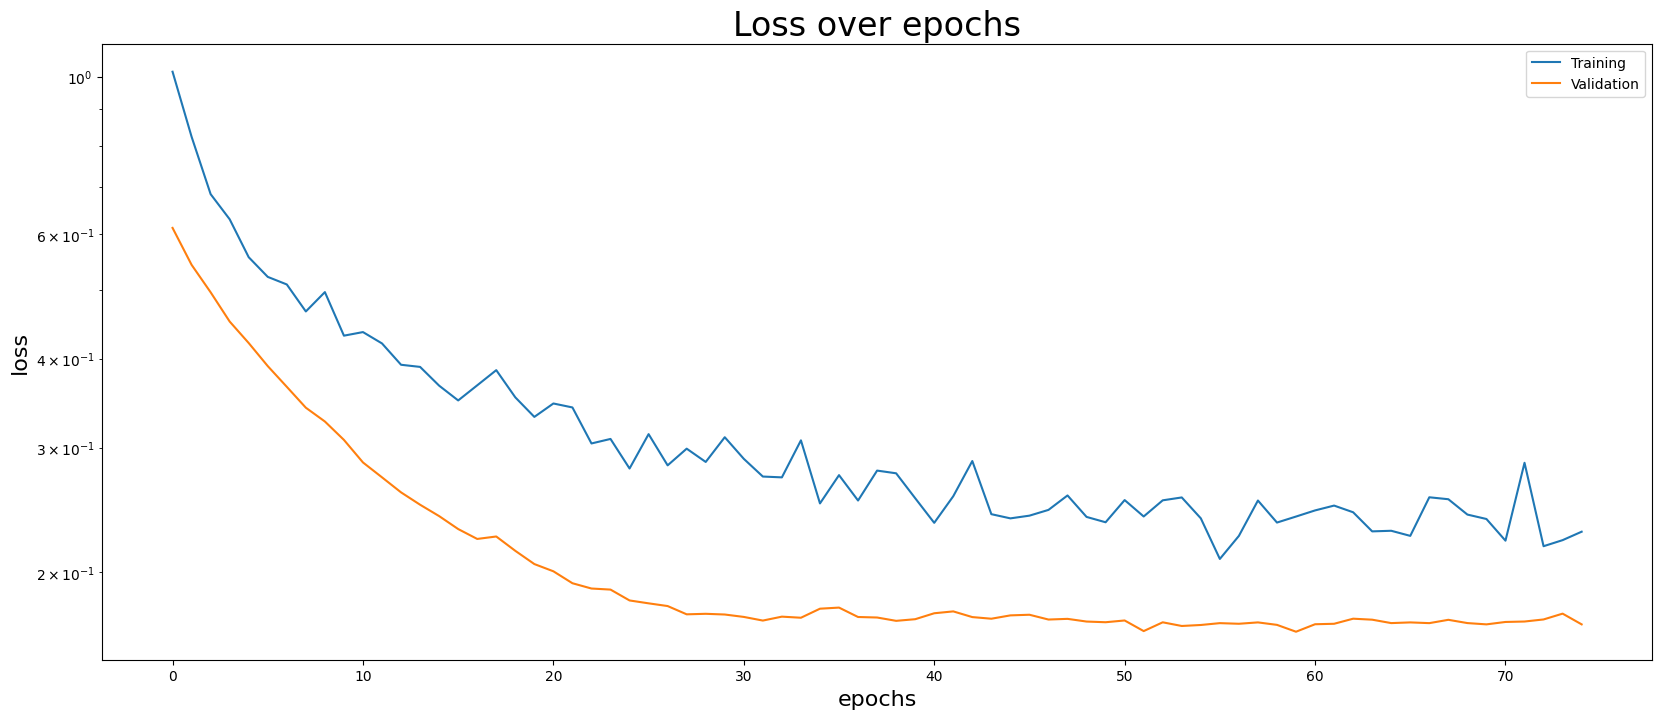

In [38]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

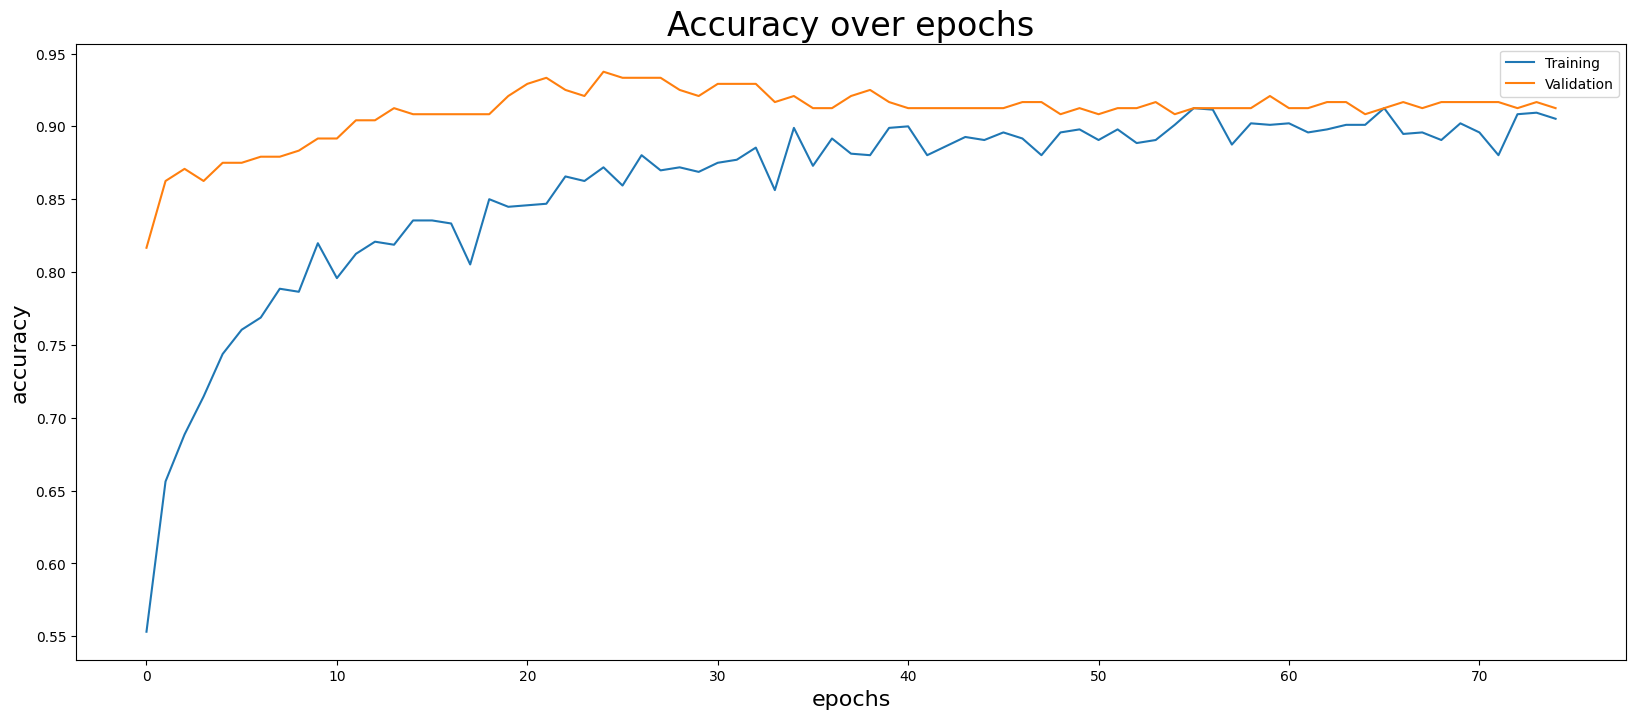

In [39]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

In [40]:
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final validation accuracy: {val_accuracy * 100:.2f}%")
val_loss, val_accuracy

Final validation accuracy: 91.25%


(0.1688629537820816, 0.9125000238418579)

In [41]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

26/38 [===================>..........] - ETA: 0s - loss: 0.1387 - accuracy: 0.9435

38/38 [==============================] - 0s 2ms/step - loss: 0.1464 - accuracy: 0.9375


(0.14643023908138275, 0.9375)

In [42]:
test_loss, test_metric = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.9267


(0.1940552145242691, 0.9266666769981384)

# Step 5: Choosing data set for evaluation

In [43]:
use_new_data_for_evaluation = False
# how many months after training?
iteration = 36 # final month in dataset, should have the biggest difference
# iteration = 12 # one year later, drift should start to show

In [44]:
import pandas as pd

if not use_new_data_for_evaluation:
  # original (old) data
  df = pd.read_csv(url_for_dataset(f'reference'), delimiter=';')
else:
  # new data
  df = pd.read_csv(url_for_dataset(f'monthly/month-{iteration}'), delimiter=';')


In [45]:
df = drop_unimportant_features(df)
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'milage', 'risk', 'group_name', 'group', 'good_customer'],
      dtype='object')

In [46]:
y = df['good_customer'].values  # binary classification
np.unique(y, return_counts=True)

(array([0, 1]), array([845, 655]))

In [47]:
df = df.round(1)
df.head()

,training,age,emergency_braking,braking_distance,power,milage,risk,group_name,group,good_customer
0,0,42.0,0,40.9,122.2,98.5,3.7,high,0,0
1,0,24.4,1,44.8,113.8,46.3,2.4,medium,1,0
2,0,18.3,1,41.6,143.4,76.9,4.1,high,0,0
3,0,51.3,1,47.3,111.6,102.7,5.1,high,0,0
4,0,23.6,0,42.8,146.0,63.7,3.7,high,0,0


In [48]:
X = df.drop(['risk', 'group', 'group_name', 'good_customer'], axis='columns').values

In [49]:
from sklearn.model_selection import train_test_split
# FIXME: does not make sense when this is a completely new dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1200, 6), (300, 6), (1200,), (300,))

In [50]:
_, train_metric = model.evaluate(X_train, y_train, verbose=0)
train_metric

0.9375

In [102]:
_, test_metric = model.evaluate(X_test, y_test, verbose=0)
test_metric

0.9266666769981384

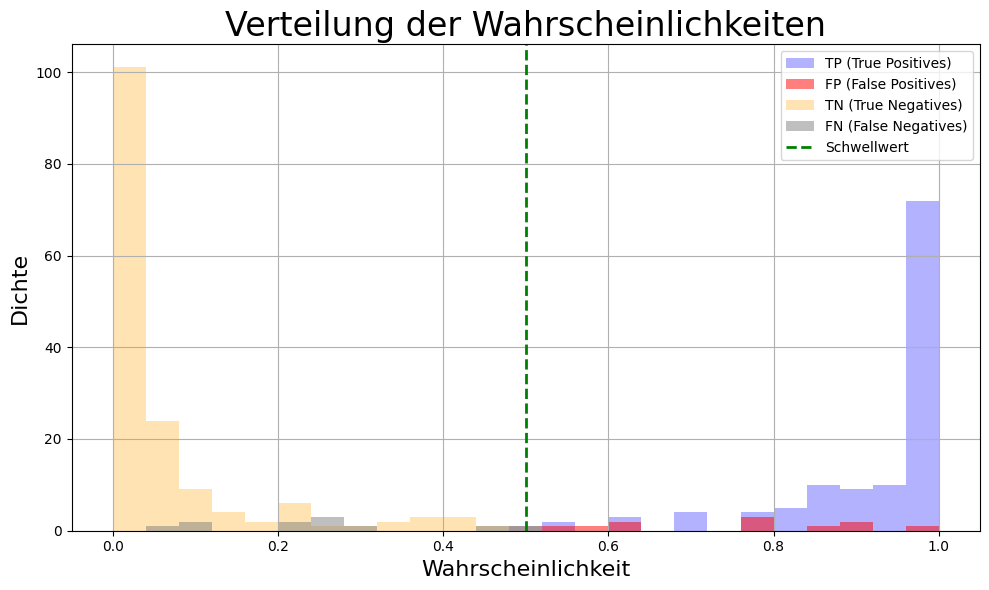

In [111]:
threshold = 0.5
bins=25

X = X_test
y_true = y_test
# X = X_train
# y_true = y_train

y_hat = model.predict(X, verbose=0).squeeze()
TP_probabilities = y_hat[(y_true == 1) & (y_hat >= threshold)]
FP_probabilities = y_hat[(y_true == 0) & (y_hat >= threshold)]
TN_probabilities = y_hat[(y_true == 0) & (y_hat < threshold)]
FN_probabilities = y_hat[(y_true == 1) & (y_hat < threshold)]

plt.figure(figsize=(10, 6))

plt.hist(TP_probabilities, bins=bins, range=(0,1), color='blue', alpha=0.3, label='TP (True Positives)')
plt.hist(FP_probabilities, bins=bins, range=(0,1), color='red', alpha=0.5, label='FP (False Positives)')
plt.hist(TN_probabilities, bins=bins, range=(0,1), color='orange', alpha=0.3, label='TN (True Negatives)')
plt.hist(FN_probabilities, bins=bins, range=(0,1), color='gray', alpha=0.5, label='FN (False Negatives)')


# Add a vertical line for the threshold
plt.axvline(threshold, color='green', linestyle='dashed', linewidth=2, label='Schwellwert')

# Adding titles and labels
plt.title('Verteilung der Wahrscheinlichkeiten')
plt.xlabel('Wahrscheinlichkeit')
plt.ylabel('Dichte')
# plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


# Step 6: Check Invariant Properties of Model

## Accuracy range and lack of overfitting

In [52]:
# 85% is sufficient for our use case
assert train_metric > .85

In [53]:
assert test_metric > .85

In [54]:
assert abs(train_metric - test_metric) < .05

In [55]:
# we can not be too good, this would be a suspicious

assert test_metric < .95
assert train_metric < .95

## Distribution of Output Class

In [56]:
threshold = .5
y_pred = (model.predict(X) > threshold).astype("int32")
y_pred.shape

47/47 [==============================] - 0s 2ms/step


(1500, 1)

In [57]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1], dtype=int32), array([834, 666]))

In [58]:
# equal distribution around classes expected
tolerance = 0.25
expected_count = len(X) / len(values)
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')

for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

562-937
834
666


## Invariants of the model itself
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization
* probabilty distribution

**We do not use these properties as we want to treat the model as a black box to make it interchangable**

# Step 7: Calculating Business KPI (Key Performance Indicator)

In [59]:
y_true = y_test
threshold = .5
y_pred = (model.predict(X_test) > threshold).astype("int32")
y_true.shape, y_pred.shape


10/10 [==============================] - 0s 2ms/step


((300,), (300, 1))

In [60]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
tn, fp, fn, tp

(158, 11, 11, 120)

In [61]:
# costs and benefits
cost_fp = 5_000  # cost of a false positive
reward_tp = 1000  # reward of a true positive
cost_fn = 1000  # cost of a false negative

kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
kpi_per_case = round(kpi  / len(y_true))

print(f"KPI: ${kpi_per_case}")


KPI: $180


In [62]:
# kpi depends on where we make the split between good and bad customers
def kpi_for_threshold(X, y_true, threshold):
    y_pred = (model.predict(X, verbose=0) > threshold).astype("int32")
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    kpi = (tp * reward_tp) - (fp * cost_fp) - (fn * cost_fn)
    kpi_per_case = round(kpi  / len(y_true))
    return kpi_per_case, (tn, fp, fn, tp)

In [63]:
kpi_for_threshold(X_test, y_test, threshold=.5)

(180, (158, 11, 11, 120))

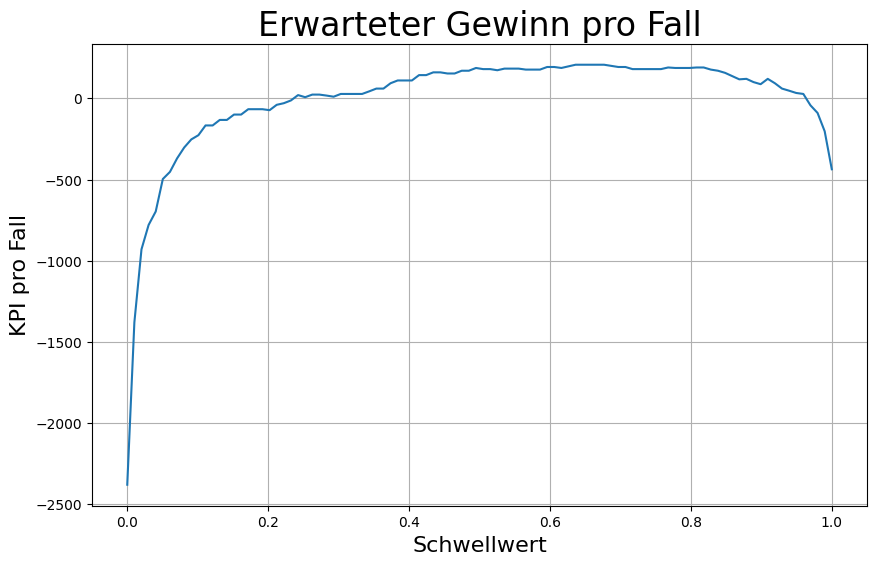

In [115]:
thresholds = np.linspace(0, 1, 100)
kpi_values = []

plt.figure(figsize=(10, 6))

# Calculate KPI for each threshold
for threshold in thresholds:
    kpi, _ = kpi_for_threshold(X_test, y_test, threshold)
    kpi_values.append(kpi)

# Plotting the results
plt.plot(thresholds, kpi_values)
plt.xlabel('Schwellwert')
plt.ylabel('KPI pro Fall')
# plt.yscale('log')
plt.title('Erwarteter Gewinn pro Fall')
plt.grid(True)
plt.show()


In [65]:
best_kpi = max(kpi_values)
best_threshold = thresholds[np.array(kpi_values).argmax()]
_, (tn, fp, fn, tp) = kpi_for_threshold(X_test, y_test, best_threshold)
print(f"Best KPI ${best_kpi} for threshold {best_threshold}")
tn, fp, fn, tp

Best KPI $207 for threshold 0.6363636363636365


(162, 7, 17, 114)

## Business tells us that the whole case only makes sense above a certain expeced profit per case and certain percentage of people getting insurance

In our case this is 
* 150$ profit per case
* and at least 1/3 of people getting insurance

In [66]:
assert best_kpi > 150

In [67]:
rate_people_getting_insurance = (tp + fp) / len(y_test)
rate_people_getting_insurance

0.4033333333333333

In [68]:
assert rate_people_getting_insurance > 1/3

# Step 8: Saving Model when validation holds

In [69]:
model.save('classifier-binary.keras', save_format='keras')

In [70]:
model.save('classifier-binary', save_format='tf')
!tar czvf classifier-binary.tgz ./classifier-binary

INFO:tensorflow:Assets written to: classifier-binary/assets


INFO:tensorflow:Assets written to: classifier-binary/assets


./classifier-binary/
./classifier-binary/saved_model.pb
./classifier-binary/variables/
./classifier-binary/variables/variables.index
./classifier-binary/variables/variables.data-00000-of-00001
./classifier-binary/assets/
./classifier-binary/fingerprint.pb
./classifier-binary/keras_metadata.pb


In [71]:
!ls -l

total 12232
-rw-r--r-- 1 olli olli 11073610 Nov  3 19:22 analysis.ipynb
drwxr-xr-x 4 olli olli     4096 Nov  2 18:49 classifier
drwxr-xr-x 4 olli olli     4096 Dec  3 12:15 classifier-binary
-rw-r--r-- 1 olli olli   185946 Dec  3 12:15 classifier-binary.keras
-rw-r--r-- 1 olli olli   162422 Dec  3 12:15 classifier-binary.tgz
drwxr-xr-x 3 olli olli     4096 Nov  1 22:26 datasets
-rw-r--r-- 1 olli olli   167814 Nov 27 16:09 drift-detection.ipynb
-rw-r--r-- 1 olli olli    67487 Dec  3 12:15 model.png
-rw-r--r-- 1 olli olli   844960 Dec  3 12:15 train.ipynb
